# Visualize Amazon Customer Reviews Dataset - Part 2

### Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
%%bash
pip install -q --upgrade pip
pip install -q pandas==0.23.0
pip install -q numpy==1.14.3
pip install -q matplotlib==3.0.3
pip install -q seaborn==0.8.1
pip install -q PyAthena==1.8.0

In [2]:
# Imports & Settings

import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

In [3]:
# PyAthena imports
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [4]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

#### Set Seaborn parameters in advance

In [5]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
             'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
           'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

In [6]:
# Helper code to display values on bars

def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

### 1. Which product categories are the highest rated by average rating?

In [7]:
# SQL statement
statement = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{} 
GROUP BY product_category 
ORDER BY avg_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM dsoaws.amazon_reviews_parquet 
GROUP BY product_category 
ORDER BY avg_star_rating DESC



In [8]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,avg_star_rating
0,Gift Card,4.731363
1,Digital_Music_Purchase,4.642891
2,Music,4.436624
3,Books,4.341658
4,Grocery,4.312219
5,Digital_Ebook_Purchase,4.308775
6,Video DVD,4.302017
7,Tools,4.261769
8,Musical Instruments,4.251103
9,Automotive,4.246302


In [9]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

43


#### Visualizations

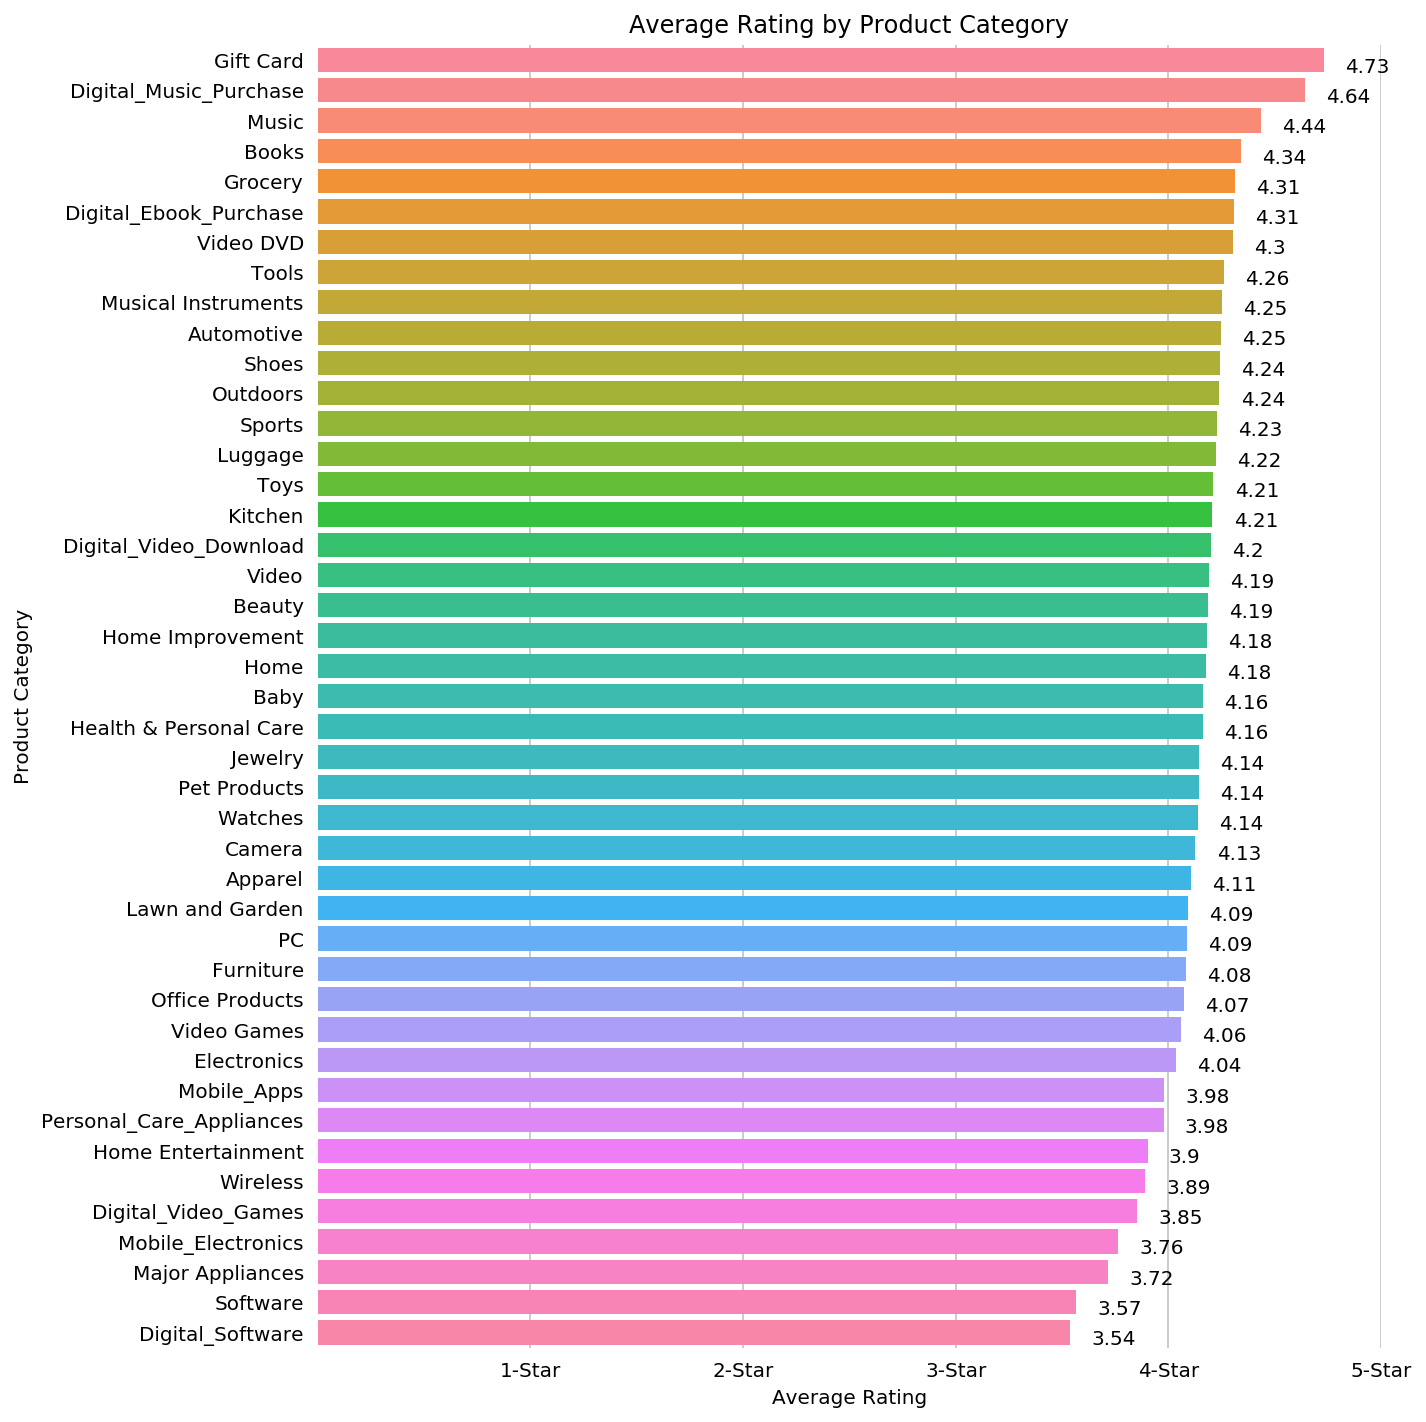

In [10]:
# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df, saturation=1)

if num_categories < 8:
    plt.figure(figsize=(10,5))
    
# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

### 2. Which product categories have the most reviews?

In [11]:
# SQL statement
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category 
ORDER BY count_star_rating DESC



In [12]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,count_star_rating
0,Books,19531329
1,Digital_Ebook_Purchase,17622415
2,Wireless,9002021
3,PC,6908554
4,Home,6221559
5,Apparel,5906333
6,Health & Personal Care,5331449
7,Beauty,5115666
8,Video DVD,5069140
9,Mobile_Apps,5033376


In [13]:
# Store counts
count_ratings = df['count_star_rating']

# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

19531329


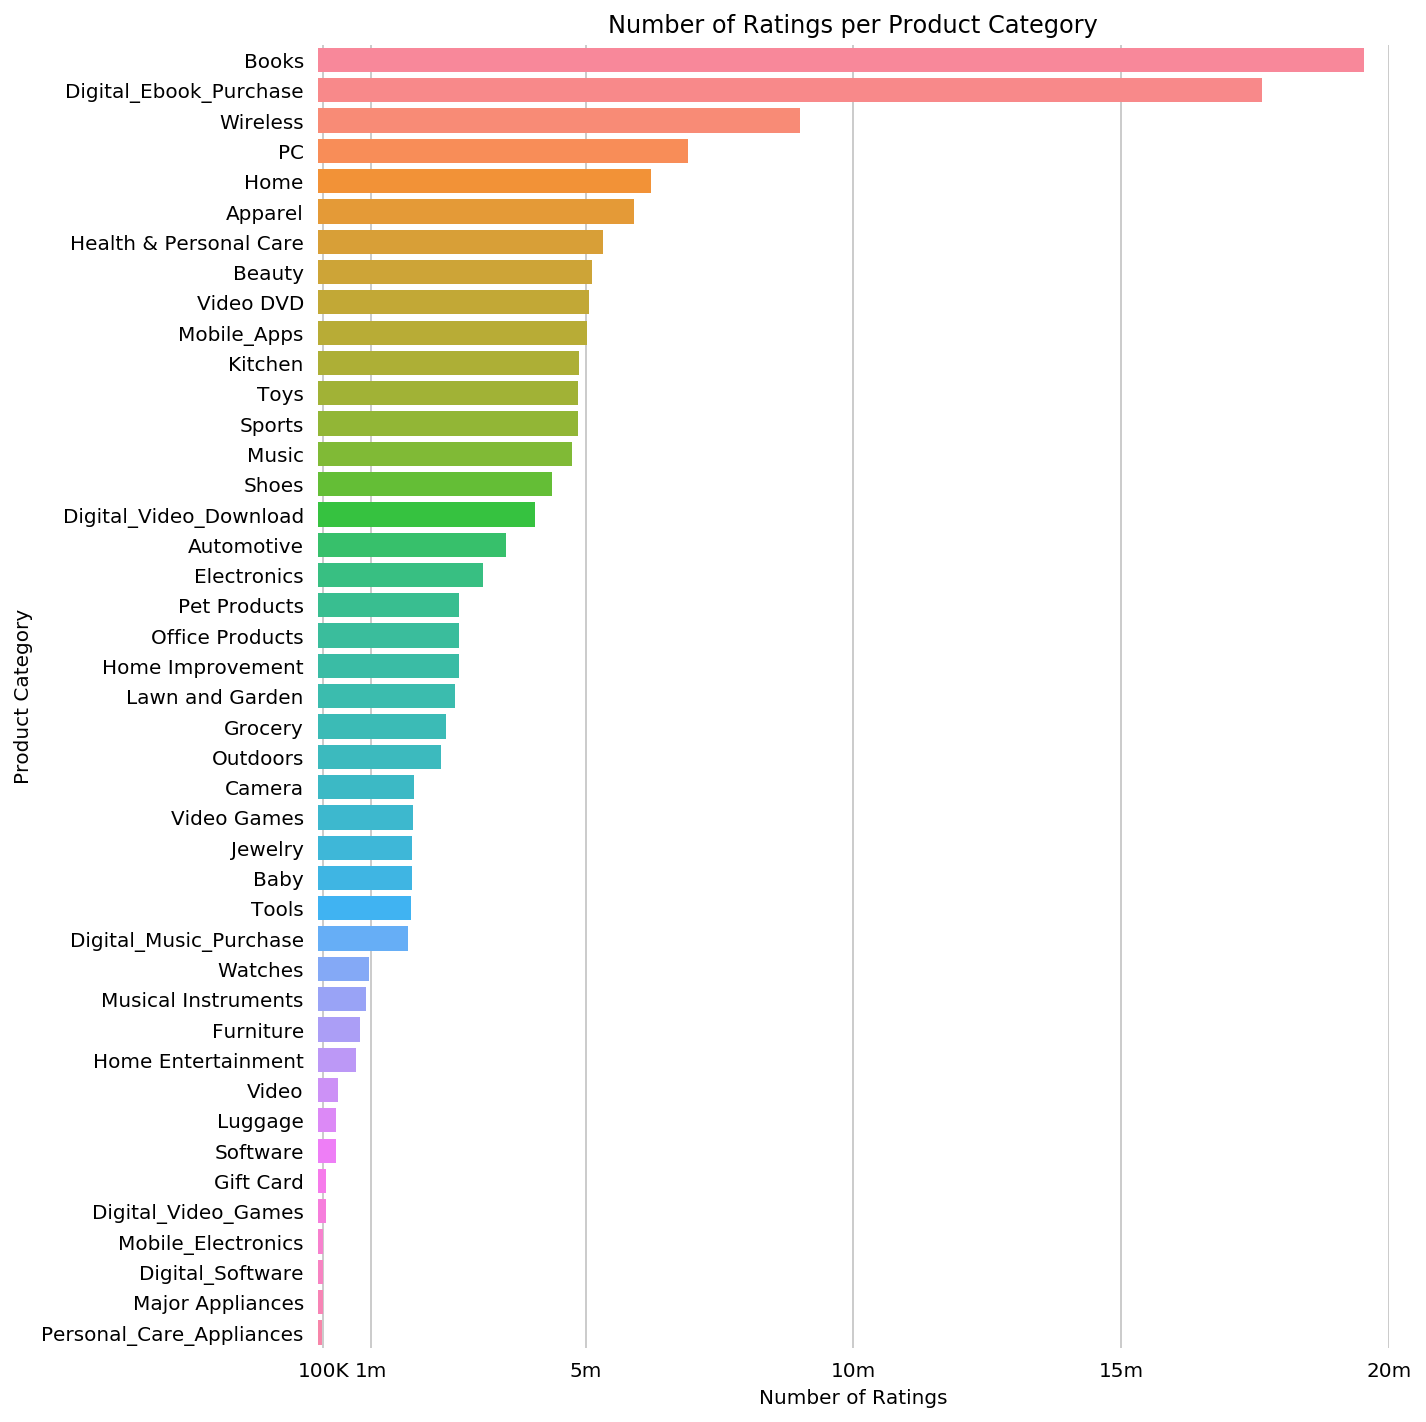

In [14]:
# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

if num_categories < 8:
    plt.figure(figsize=(10,5))

# Set title
plt.title("Number of Ratings per Product Category")

# Set x-axis ticks to match scale 
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

### 3. When did each product category become available in the catalog based on the date of the first review?

In [15]:
# SQL statement -- ANTJE
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(database_name, table_name)

print(statement)


SELECT product_category, MIN(review_date) AS first_review_date
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category
ORDER BY first_review_date 



In [16]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,first_review_date
0,Books,1995-06-24
1,Music,1995-11-11
2,Video,1995-11-11
3,Video DVD,1996-07-08
4,Toys,1997-01-05
5,Sports,1997-10-09
6,Video Games,1997-11-06
7,Home,1998-05-29
8,Office Products,1998-07-15
9,Pet Products,1998-08-23


In [17]:
# Convert date strings (e.g. 2014-10-18) to datetime
import datetime as datetime
dates = pd.to_datetime(df['first_review_date'])


In [18]:
# See: https://stackoverflow.com/questions/60761410/how-to-graph-events-on-a-timeline

def modify_dataframe(df):
    """ Modify dataframe to include new columns """
    df['year'] = pd.to_datetime(df['first_review_date'], format='%Y-%m-%d').dt.year
    return df

def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df['year'].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values


In [19]:
new_df = modify_dataframe(df)
print(new_df)

X, Y = get_x_y(new_df)
print(X)
print(Y)

            product_category first_review_date  year
0                      Books        1995-06-24  1995
1                      Music        1995-11-11  1995
2                      Video        1995-11-11  1995
3                  Video DVD        1996-07-08  1996
4                       Toys        1997-01-05  1997
5                     Sports        1997-10-09  1997
6                Video Games        1997-11-06  1997
7                       Home        1998-05-29  1998
8            Office Products        1998-07-15  1998
9               Pet Products        1998-08-23  1998
10                  Software        1998-09-21  1998
11        Home Entertainment        1998-10-15  1998
12                    Camera        1998-11-20  1998
13                  Wireless        1998-12-04  1998
14    Health & Personal Care        1999-02-06  1999
15                  Outdoors        1999-03-24  1999
16               Electronics        1999-06-09  1999
17                        PC        1999-07-01

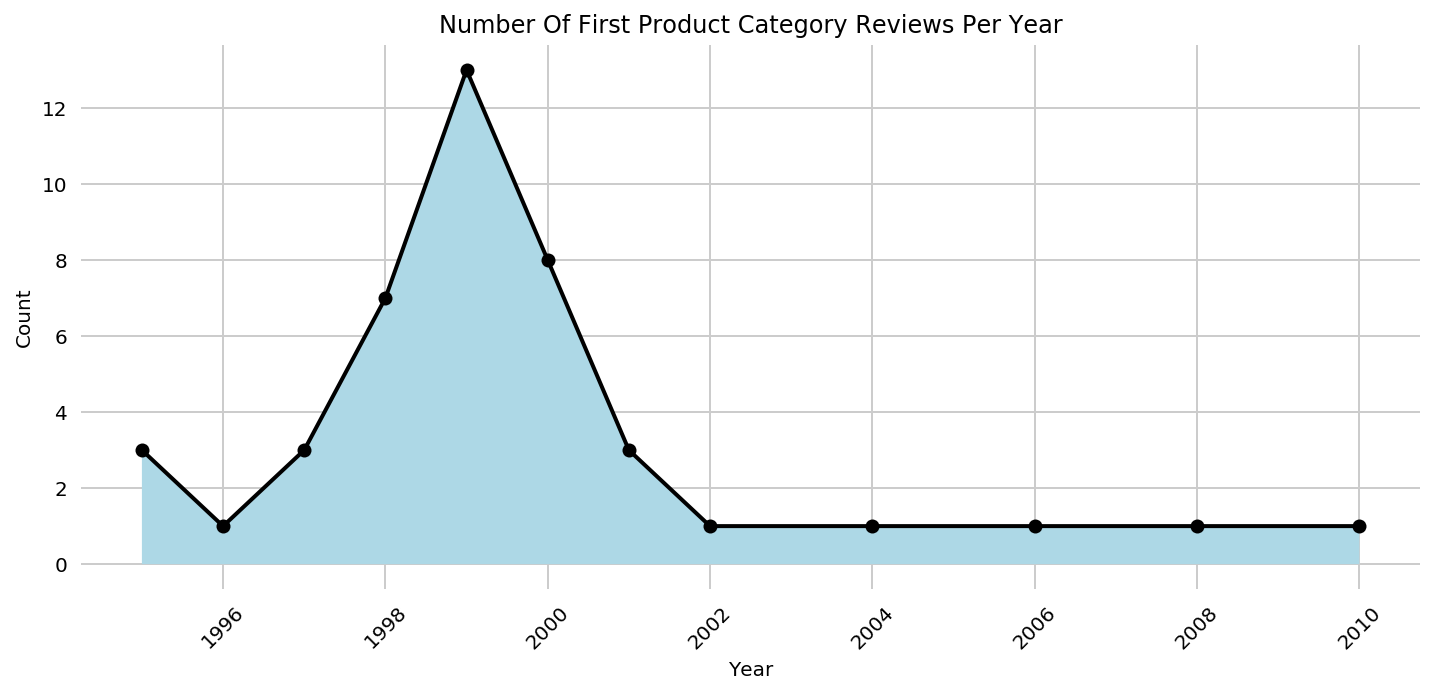

In [20]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1, title='Number Of First Product Category Reviews Per Year')

xlabels = pd.period_range('1995', periods=21, freq='Y')

ax.set_xlabel('Year')
ax.set_ylabel('Count')

#ax.set_xticks(range(xlabels.shape[0]))
#ax.set_xticklabels(xlabels, rotation=45, ha='right')

plt.xticks(rotation=45)

ax.fill_between(X, [0]*len(X), Y, facecolor='lightblue')
ax.plot(X, Y, color="black", linewidth=2, marker="o")

plt.savefig('first_reviews_per_year.png', format='png')
plt.show() 

### 4. What is the breakdown of ratings (1-5) per product category?  


In [21]:
# SQL statement 
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [22]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Apparel,5,3320566
1,Apparel,4,1147237
2,Apparel,3,623471
3,Apparel,2,369601
4,Apparel,1,445458
5,Automotive,5,2300757
6,Automotive,4,526665
7,Automotive,3,239886
8,Automotive,2,147767
9,Automotive,1,299867


#### Stacked percentage horizontal bar plot showing proportion of star ratings per product category

In [23]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby('product_category')
grouped_star = df.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df.groupby(['star_rating']).sum()

# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

150962278


In [24]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)


{'Apparel': [3320566, 1147237, 623471, 369601, 445458], 'Automotive': [2300757, 526665, 239886, 147767, 299867], 'Baby': [1070258, 287370, 149935, 100956, 144413], 'Beauty': [3254909, 741434, 398402, 264029, 456892], 'Books': [12874022, 3352504, 1452686, 808056, 1044061], 'Camera': [1062707, 336701, 141460, 90949, 170157], 'Digital_Ebook_Purchase': [10632313, 3983850, 1568686, 690426, 747140], 'Digital_Music_Purchase': [1345149, 207333, 62404, 25018, 48980], 'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Download': [2446375, 767302, 350900, 198566, 294004], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Electronics': [1781161, 536821, 238587, 179180, 358120], 'Furniture': [447716, 153666, 73563, 43848, 73320], 'Gift Card': [129709, 9859, 3156, 1569, 4793], 'Grocery': [1662261, 293389, 161495, 105265, 180048], 'Health & Personal Care': [3358258, 781760, 400428, 277981, 513022], 'Home': [3893005, 959228, 500416, 324062, 544848], 'Home Entertainment': [

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [25]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift Card', 'Grocery', 'Health & Personal Care', 'Home', 'Home Entertainment', 'Home Improvement', 'Jewelry', 'Kitchen', 'Lawn and Garden', 'Luggage', 'Major Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical Instruments', 'Office Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video DVD', 'Video Games', 'Watches', 'Wireless'])


In [26]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Apparel', [3320566, 1147237, 623471, 369601, 445458]), ('Automotive', [2300757, 526665, 239886, 147767, 299867]), ('Baby', [1070258, 287370, 149935, 100956, 144413]), ('Beauty', [3254909, 741434, 398402, 264029, 456892]), ('Books', [12874022, 3352504, 1452686, 808056, 1044061]), ('Camera', [1062707, 336701, 141460, 90949, 170157]), ('Digital_Ebook_Purchase', [10632313, 3983850, 1568686, 690426, 747140]), ('Digital_Music_Purchase', [1345149, 207333, 62404, 25018, 48980]), ('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Download', [2446375, 767302, 350900, 198566, 294004]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970]), ('Electronics', [1781161, 536821, 238587, 179180, 358120]), ('Furniture', [447716, 153666, 73563, 43848, 73320]), ('Gift Card', [129709, 9859, 3156, 1569, 4793]), ('Grocery', [1662261, 293389, 161495, 105265, 180048]), ('Health & Personal Care', [3358258, 781760, 400428, 277981, 513022]), ('Home', [3893005, 959228, 5004

#### Build array per star across all categories

In [27]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:,0]
for index, value in average_star_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [28]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star1.append(stars[4])
    star2.append(stars[3])
    star3.append(stars[2])
    star4.append(stars[1])
    star5.append(stars[0])

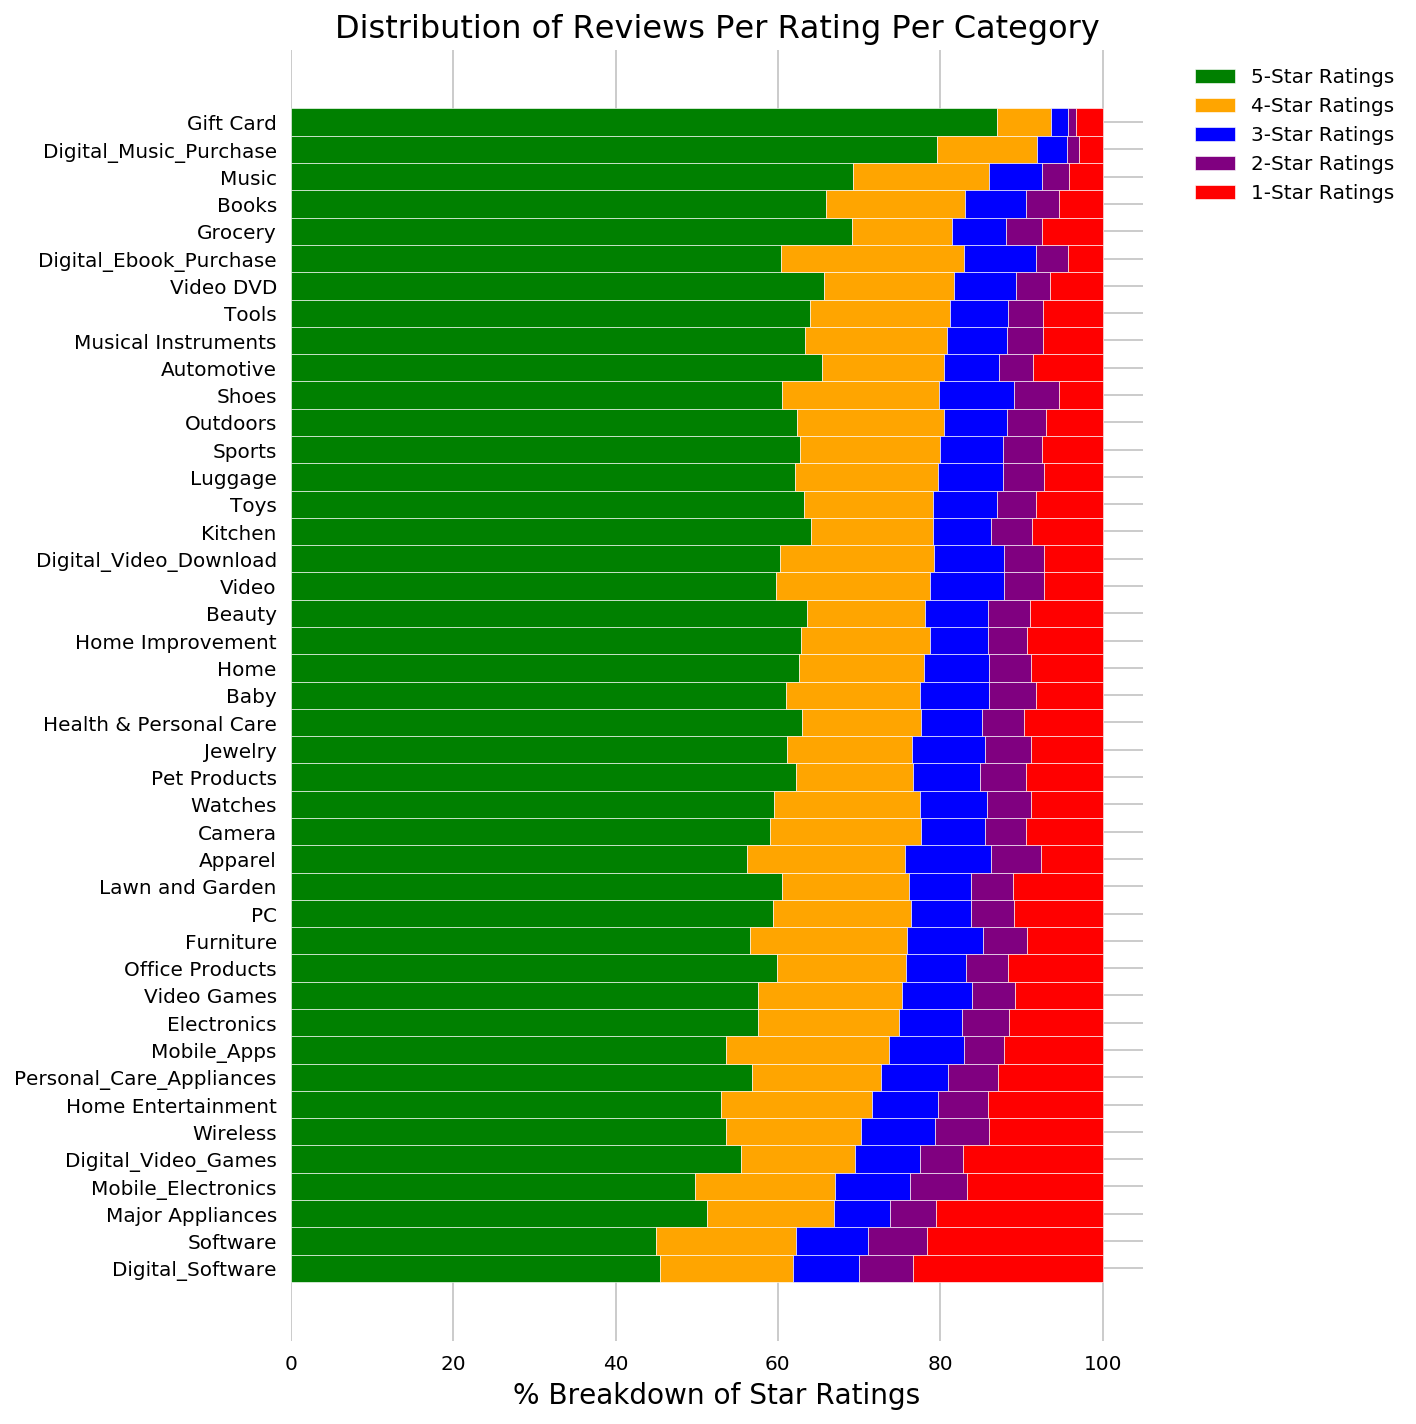

In [29]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('proportion_star_per_category.png', dpi=300)
plt.show()


#### We can also quickly group by star ratings and count the reviews for each rating (5, 4, 3, 2, 1): 

In [30]:
# SQL statement 
statement = """
SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 
""".format(database_name, table_name)

print(statement)


SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 



In [31]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

,star_rating,count_reviews
0,5,93200812
1,4,26223470
2,3,12133927
3,2,7304430
4,1,12099639


### [[ 5. Which star ratings (1-5) are the most helpful? ]]

In [ ]:
# SQL statement 
statement = """
SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM {}.{}
GROUP BY  star_rating
ORDER BY  star_rating DESC
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization

### [[ 6. Which products have the most helpful reviews?  How long are those reviews? ]]

In [ ]:
# SQL statement 
statement = """
SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM {}.{}
ORDER BY helpful_votes DESC LIMIT 10 
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization

### [[ 8. Which customers have written the most helpful reviews?  ]]
And how many reviews have they written?  
Across how many categories?  What is their average star rating?

In [ ]:
# SQL statement 
statement = """
SELECT customer_id,
       ROUND(AVG(helpful_votes),1) AS avg_helpful_votes,
       COUNT(*) AS review_count,
  COUNT(DISTINCT product_category) AS 
product_category_count,
       ROUND(AVG(star_rating),1) AS avg_star_rating
FROM {}.{}
GROUP BY  customer_id
HAVING count(*) > 100
ORDER BY avg_helpful_votes DESC LIMIT 10;
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization

### [[ 9. What is the ratio of positive to negative reviews? ]]

In [ ]:
# SQL statement 
statement = """
SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
FROM (
  SELECT count(*) AS positive_review_count
  FROM {}.{}
  WHERE star_rating >= 4
), (
  SELECT count(*) AS negative_review_count
  FROM {}.{}
  WHERE star_rating < 4
)
""".format(database_name, table_name, database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization

### 10. How have ratings changed over time?  ie. has the average rating become more or less critical over the years?

In [ ]:
# SQL statement 
statement = """
SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM {}.{}
GROUP BY year
ORDER BY year
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization

### 11. Which customers are abusing the review system by repeatedly reviewing the same product more than once?  What was their average star rating for each product?

In [ ]:
# SQL statement 
statement = """
SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM dsoaws.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

In [ ]:
# TODO: Visualization